<a href="https://www.kaggle.com/code/annamalkova88/ovarian-cancer-myvers?scriptVersionId=152875314" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:violet; border:0; color:white' role="tab" aria-controls="home"><center>Application for Ovarian Cancer Subtype Classification</center></h2>

## Actuality
Ovarian carcinoma is the most lethal cancer of the female reproductive system. There are five common subtypes of ovarian cancer: high-grade serous carcinoma, clear-cell ovarian carcinoma, endometrioid, low-grade serous, and mucinous carcinoma. Recently histological diagnosis have several challenges, including disagreements between observers and the reproducibility of diagnostics. Furthermore, underserved communities often lack access to specialist pathologists, and even well-developed communities face a shortage of pathologists with expertise in gynecologic malignancies.

## The aim of the project
to improve accuracy in identifying ovarian cancer subtypes with histological images  using Deep Learning algorithms 


<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:violet; border:0; color:white' role="tab" aria-controls="home"><center>Quick navigation</center></h2>

* [0. Installation of libraries](#0)
* [1. Basic Data Overview](#1)
* [2. Transformation of data](#2)
* [3. Convolutional networks](#3)
* [4. Conclusions](#4)
    

<a id="0"></a>
<h2 style='background:violet; border:0; color:white'><center>0. Installation of libraries</center><h2>

In [ ]:
#pip install opencv-python

In [ ]:
#pip install rembg

In [ ]:
import numpy as np
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import imageio
import plotly.express as px
from skimage import io 
from PIL import Image
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

<a id="1"></a>
<h2 style='background:violet; border:0; color:white'><center>1. Basic Data Overview</center><h2>

In [ ]:
train_df = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
display(train_df.head(),
        train_df.info(), 
        'Missing values',
        train_df.isna().sum())

In [ ]:
fig=px.histogram(train_df.groupby(['label','is_tma'],as_index=False)['is_tma'].value_counts(),
                 x='label', 
                 y='count',
                 color='is_tma',
                 text_auto=True,
                 title='Distribution of histological types'
                )
fig.show()

Because of the limit of memory the work will be proceeded with thumbnail files

In [ ]:
train_df['filename'] = train_df['image_id'].astype(str)+'_thumbnail.png'
file_paths = {}
for root, _, files in os.walk('/kaggle/input/UBC-OCEAN/train_thumbnails'):
    for filename in files:
        path = os.path.join(root, filename)  
        file_paths[filename]=path
        
train_df['path'] = train_df['filename'].map(file_paths)
train_df.head()

In [ ]:
train_df.dropna(axis=0, inplace=True)

In [ ]:
fig=px.histogram(train_df.groupby(['label','is_tma'],as_index=False)['is_tma'].value_counts(),
                 x='label', 
                 y='count',
                 color='is_tma',
                 text_auto=True,
                 title='Distribution of histological types'
                )
fig.show()

We see that the data is imbalanced, which can be a problem for further modelling

In [ ]:
import matplotlib.image as mpimg

labels = train_df['label'].unique()
image_paths = []

for label in labels:
    path = train_df[train_df['label'] == label].sample(n=1, random_state=42)['path'].values[0]
    image_paths.append(path)
fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 5))

for i, path in enumerate(image_paths):
    img = mpimg.imread(path)
    axes[i].imshow(img)
    axes[i].set_title(labels[i])
    axes[i].axis('off')

plt.show()


We see that the format of pictures and of slices are variable, which can be also a cause of bad predictions.

## First experiments (werent included)
The first modelling with basic augmentation, artificial networks with different parameters (activation (sigmoid/relu) and optimizing (adam/sgd) functions) showed very low accuracy - just 43% were detected correctly:

accuracy: 0.4208

val_accuracy: 0.4297

The data and the model should be improved

<a id="2"></a>
<h2 style='background:violet; border:0; color:white'><center>2. Transformation of data</center><h2>

# 0.Decrease the images size

In [ ]:
def small(image,n):
    height, width, _ = image.shape
    new_width = int(width/n)  # specify the new width
    new_height = int(height * (new_width / width))  # calculate the new height to maintain the aspect ratio
    resized_img = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_img

In [ ]:
output_folder = '/kaggle/working/train_small/'
os.makedirs(output_folder, exist_ok=True)
train_df.reset_index(inplace=True)

for i in range(train_df.shape[0]):
    input_path = train_df.loc[i, 'path']
    image = cv2.imread(input_path)
    resized_img = small(image,2)
    output_path = os.path.join(output_folder, train_df.loc[i, 'filename'])
    cv2.imwrite(output_path, resized_img)

In [ ]:
train_small=train_df.copy()
file_paths = {}
for root, _, files in os.walk('/kaggle/working/train_small/'):
    for filename in files:
        path = os.path.join(root, filename)  
        file_paths[filename]=path
        
train_small['path'] = train_small['filename'].map(file_paths)
train_small.head()

# 1. Transformtion of doubled pictures

## 1.1. Selection of doubled images in dataset

In [ ]:
def plot40(image_paths,image_ids):
    num_rows = 5
    num_cols = 8
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(image_paths):
            img_path = image_paths[i]
            img_id = image_ids[i]
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(f"Image ID: {img_id}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
mc_df = train_small[train_small['label'] == 'MC']
image_paths = mc_df['path'].unique()
image_ids = mc_df['image_id'].unique()
plot40(image_paths,image_ids)

In [ ]:
lgsc_df = train_small[train_small['label'] == 'LGSC']
image_paths = lgsc_df['path'].unique()
image_ids = lgsc_df['image_id'].unique()
plot40(image_paths,image_ids)

In [ ]:
hgsc_df = train_small[train_small['label'] == 'HGSC']
image_paths = hgsc_df['path'].unique()
image_ids = hgsc_df['image_id'].unique()
plot40(image_paths,image_ids)

In [ ]:
cc_df = train_small[train_small['label'] == 'CC']
image_paths = cc_df['path'].unique()
image_ids = cc_df['image_id'].unique()
plot40(image_paths,image_ids)

In [ ]:
ec_df = train_small[train_small['label'] == 'EC']
image_paths = ec_df['path'].unique()
image_ids = ec_df['image_id'].unique()
plot40(image_paths,image_ids)

In [ ]:
#The images with double slices:
doubled=[14312,23523,28562,30868,35792,37190,
         39208,48502,281,2391,3092,3672,8130,
         8985,9183,25256,26862,34277,38585,
         38959,52612,54473,56500,
         1252,1295,2706,3055,5264,5307,5992,6175,6843,9341,
         1943,4827,8279,12222,12442,13526,13987,14051,15231,15470,15486,17067,18014,22290,
         2906,6793,15912,18810,21232,21910,22425,6363, 6449, 3098
        ]
four_pics = [5251,61689]
three_pics = [5852,21260,706,1666,1660,7955,10548]

In [ ]:
df = pd.concat([mc_df.iloc[:40],lgsc_df.iloc[:40]])
df = pd.concat([df,hgsc_df.iloc[:40]])
df = pd.concat([df,cc_df.iloc[:40]])
df = pd.concat([df,ec_df.iloc[:40]])

df['doubled'] = df['image_id'].apply(lambda x: '2' if x in doubled 
                                     else '3' if x in three_pics
                                     else '4' if x in four_pics
                                     else '1')

display(df.head(),
        df.info())

In [ ]:
df.doubled.value_counts()

In [ ]:
# dataset with unknown number of doubled slices
ind = df.index
predict_df = train_small[~train_small.index.isin(ind)]

predict_df.info()

## 1.2. Prediction of the doubled images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    rotation_range=40,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory="/kaggle/working/train_small",
    x_col='path',
    y_col="doubled",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(100,100))

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory="/kaggle/working/train_small",
    x_col='path',
    y_col="doubled",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(100,100))


In [ ]:
model_doubled = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # num_classes is the number of output classes
])
model_doubled.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])
model_doubled.fit(train_generator, epochs=5, validation_data=validation_generator)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=predict_df,               
    directory="/kaggle/working/train_small",  
    batch_size=32,                      
    seed=42,                            
    shuffle=False,                      # Set shuffle to False for test data
    target_size=(100, 100),             
    class_mode=None,                    # Set class_mode to None because there are no labels for test data
    x_col='path'                        
)
predictions = model_doubled.predict(test_generator)
predicted_classes = []
classes = ['1', '2', '3', '4']

for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]  
    predicted_classes.append(predicted_class)  
predict_df_copy = predict_df.copy()
predict_df_copy.loc[:, 'doubled'] = predicted_classes

In [ ]:
predict_df_copy.doubled.value_counts(normalize=True)

In [ ]:
train = pd.concat([predict_df_copy,df])
display(train.info(),
       train.head())

In [ ]:
# check if we marked doubled slices correctly
doub_df = train[train['doubled'] == '2'].sample(n=40)
image_paths = doub_df['path'].unique()
image_ids = doub_df['image_id'].unique()
plot40(image_paths,image_ids)

In [ ]:
def plot10(image_paths,image_ids):
    num_rows = 2
    num_cols = 5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        if i < len(image_paths):
            img_path = image_paths[i]
            img_id = image_ids[i]
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(f"Image ID: {img_id}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
doub_df = train[train['doubled'] == '3'].sample(n=10)
image_paths = doub_df['path'].unique()
image_ids = doub_df['image_id'].unique()
plot10(image_paths,image_ids)

In [ ]:
#in case the 4-pics werent distinguished
train.loc[train['image_id'] == 61689, 'doubled'] = '4'

In [ ]:
doub_list = train[train['doubled'] == '4']['image_id'].to_list()
image_paths = []
for pic in doub_list:
    path = train[train['image_id'] == pic]['path'].values[0]
    image_paths.append(path)

fig, axes = plt.subplots(1, len(doub_list), figsize=(20, 5))

for i, path in enumerate(image_paths):
    img = mpimg.imread(path)
    axes[i].imshow(img)
    axes[i].set_title(doub_list[i])
    axes[i].axis('off')

plt.show()

Pictures which were classified incorrectly:

as 3:61100 (6), 35909(1)

as 2:30515(3)

as 1:3264(2)

as 4: 52308(?)

In [ ]:
# Problematic pictures:
pics=[61100, 35909, 30515, 3264, 52308, 49587]
mask = train['image_id'].isin(pics)
train_filt = train.loc[~mask]
train_filt.info()

## 1.3. Crop doubled slices to keep only one picture

In [ ]:
def crop_d(image,n):
    width, height = image.size
    width = width // n
    cropped_image = image.crop((0, 0, width, height))
    return cropped_image

In [ ]:
import shutil

output_folder = '/kaggle/working/train_crop/'
os.makedirs(output_folder, exist_ok=True)
train_filt.reset_index(drop=True, inplace=True)

for i in range(train_filt.shape[0]):
    if train_filt.loc[i, 'doubled'] == '1':
        input_path = train_filt.loc[i, 'path']
        output_path = os.path.join(output_folder, train_filt.loc[i, 'filename'])
        shutil.copyfile(input_path, output_path)
    elif train_filt.loc[i, 'doubled'] == '2':
        input_path = train_filt.loc[i, 'path']
        image = Image.open(input_path)
        cropped_image = crop_d(image, 2.5)  
        output_path = os.path.join(output_folder, train_filt.loc[i, 'filename'])
        cropped_image.save(output_path)
    elif train_filt.loc[i, 'doubled'] == '3':
        input_path = train_filt.loc[i, 'path']
        image = Image.open(input_path)
        cropped_image = crop_d(image, 4.5)  
        output_path = os.path.join(output_folder, train_filt.loc[i, 'filename'])
        cropped_image.save(output_path)
    elif train_filt.loc[i, 'doubled'] == '4':
        input_path = train_filt.loc[i, 'path']
        image = Image.open(input_path)
        cropped_image = crop_d(image, 5.5)  
        output_path = os.path.join(output_folder, train_filt.loc[i, 'filename'])
        cropped_image.save(output_path)


In [ ]:
train_crop=train_filt.copy()
file_paths = {}
for root, _, files in os.walk('/kaggle/working/train_crop'):
    for filename in files:
        path = os.path.join(root, filename)  
        file_paths[filename]=path
        
train_crop['path'] = train_crop['filename'].map(file_paths)
train_crop.head()

In [ ]:
doub_df = train_crop[train_crop['doubled'] == '2'].sample(n=40)
image_paths = doub_df['path'].unique()
image_ids = doub_df['image_id'].unique()
plot40(image_paths,image_ids)

In [ ]:
doub_df = train_crop[train_crop['doubled'] == '3'].sample(n=10)
image_paths = doub_df['path'].unique()
image_ids = doub_df['image_id'].unique()
plot10(image_paths,image_ids)

In [ ]:
doub_list = train_crop[train_crop['doubled'] == '4']['image_id'].to_list()
image_paths = []
for pic in doub_list:
    path = train_crop[train_crop['image_id'] == pic]['path'].values[0]
    image_paths.append(path)

fig, axes = plt.subplots(1, len(doub_list), figsize=(20, 5))

for i, path in enumerate(image_paths):
    img = mpimg.imread(path)
    axes[i].imshow(img)
    axes[i].set_title(doub_list[i])
    axes[i].axis('off')

plt.show()

In [ ]:
# Problematic pictures
image_paths = []
pics=[59031, 16494, 48973,45254]
mask = train_crop['image_id'].isin(pics)
train_crop_filt = train_crop.loc[~mask]
train_crop_filt.info()

In [ ]:
#pip install histolab

# 2.Zooming the slices

In [ ]:
def zoom1(image, w=100, h=100):
    # Convert the image to RGBA mode (if not already in RGBA mode)
    image = image.convert('RGBA')

    # Get the image data as a list of RGBA tuples
    image_data = list(image.getdata())

    # Define the black color threshold (adjust as needed)
    black_threshold = 50

    # Create a mask to identify non-black pixels
    mask = [(0, 0, 0, 0) if all(item < black_threshold for item in pixel[:3]) else pixel for pixel in image_data]

    # Create a new image with the non-black pixels
    image.putdata(mask)

    # Find the bounding box of the non-black pixels
    bbox = image.getbbox()

    # Calculate the center of the bounding box
    center_x = (bbox[0] + bbox[2]) // 2
    center_y = (bbox[1] + bbox[3]) // 2
    
    crop_width = w
    crop_height = h
    left = center_x - crop_width
    upper = center_y - crop_height
    right = center_x + crop_width
    lower = center_y + crop_height
    
    crop_image = image.crop((left, upper, right, lower))
    return crop_image

# Example usage:
image_path = '/kaggle/working/train_crop/61689_thumbnail.png'  
image = Image.open(image_path)
zoom1(image, w=70, h=70)


In [ ]:
image_path = '/kaggle/working/train_crop/41361_thumbnail.png' 
image = Image.open(image_path)
zoom1(image, w=70, h=70)

In [ ]:
def zoom2(image, w=100, h=100):
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to create a binary mask
    _, binary_mask = cv2.threshold(grayscale_image, 1, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the center of the largest contour
    M = cv2.moments(largest_contour)
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    
    crop_width = w
    crop_height = h
    left = max(center_x - crop_width, 0)
    upper = max(center_y - crop_height, 0)
    right = min(center_x + crop_width, image.shape[1])
    lower = min(center_y + crop_height, image.shape[0])
    
    crop_image = Image.fromarray(image[upper:lower, left:right])
    return crop_image

# Example usage:
image_path = '/kaggle/working/train_crop/41361_thumbnail.png' 
image = cv2.imread(image_path)
zoom2(image, w=70, h=70)

In [ ]:
image_path = '/kaggle/working/train_crop/61689_thumbnail.png'  
image = cv2.imread(image_path)
zoom2(image, w=70, h=70)

In [ ]:
#one of the zoom options

#output_folder = '/kaggle/working/train_crop_zoom_white/'
#os.makedirs(output_folder, exist_ok=True)
#train_crop_filt.reset_index(drop=True, inplace=True)
#for i in range(train_crop_filt.shape[0]):
    #input_path = train_crop_filt.loc[i, 'path']
    #image = cv2.imread(input_path)
    #image = zoom2(image, w=70, h=70) 
    #output_path = os.path.join(output_folder, train_crop_filt.loc[i, 'filename'])
    #image.save(output_path)

In [ ]:
output_folder = '/kaggle/working/train_crop_zoom_white/'
os.makedirs(output_folder, exist_ok=True)
train_crop_filt.reset_index(drop=True, inplace=True)
for i in range(train_crop_filt.shape[0]):
    input_path = train_crop_filt.loc[i, 'path']
    image = Image.open(input_path)
    image = zoom1(image, w=100, h=100) 
    output_path = os.path.join(output_folder, train_crop_filt.loc[i, 'filename'])
    image.save(output_path)

In [ ]:
train_zoom=train_crop_filt.copy()
file_paths = {}
for root, _, files in os.walk('/kaggle/working/train_crop_zoom_white'):
    for filename in files:
        path = os.path.join(root, filename)  
        file_paths[filename]=path
        
train_zoom['path'] = train_zoom['filename'].map(file_paths)
train_zoom.head()

In [ ]:
sample = train_zoom.sample(n=40)
image_paths = sample['path'].unique()
image_ids = sample['image_id'].unique()
plot40(image_paths,image_ids)

In [ ]:
# Problematic pictures - delete all containing white background:
pics_much=[60928,1666,52612,35592,60685,30738,29331,30868,3092,2706,8985,
           32035,15912,10548,6582,3511,1080,25792,706,50246,30539,39252,
           1252,39144,54506,62828,26862,21232,31473,25331,59515,65022,
          34688,15583,7955,46815,18896,34845,7955,54825,57100,47431]
pics_few = [60928,64824,52420,39365,11559,2666,15470,14542,30738,17738,
            18196,19512,48861,60287,26644,45104,36008,
           14051,56843,36008,57265,45104,61689,43998]
pics = pics_much+pics_few
mask = train_zoom['image_id'].isin(pics)
train_zoom_filt = train_zoom.loc[~mask]
train_zoom_filt.info()

In [ ]:
sample = train_zoom_filt.sample(n=40)
image_paths = sample['path'].unique()
image_ids = sample['image_id'].unique()
plot40(image_paths,image_ids)

<a id="3"></a>
<h2 style='background:violet; border:0; color:white'><center>3. Convolutional network model</center><h2>

# Image Augmentation:

***rotation_range***: Randomly rotates the images by up to x degrees. This helps the model generalize better by learning features from various angles.

***width_shift_range and height_shift_range***: Randomly shifts the images horizontally and vertically by up to x% of the image width or height. This can help the model learn position invariance.

***shear_range***: Applies shear mapping, which distorts the shape of the object. It randomly distorts the image by shearing it with a shear intensity of up to x%.

***zoom_range***: Randomly zooms into the images by up to x%. This helps the model learn to focus on specific parts of the image.

***horizontal_flip=True***: Randomly flips half of the images horizontally. This helps in situations where the orientation of the object in the image doesn't affect its classification.

***fill_mode='nearest'***: This determines the strategy used for filling in newly created pixels. 'nearest' means that the nearest existing pixel will be used to fill the new pixel values.

In [ ]:
#The target classes are imbalanced, 
#therefore split on train and validation groups will be done with stratifier

from sklearn.model_selection import StratifiedShuffleSplit
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in stratified_splitter.split(train_zoom_filt['path'], train_zoom_filt['label']):
    train_df = train_zoom_filt.iloc[train_index]
    val_df = train_zoom_filt.iloc[val_index]

#Because we work with histologic images its crucial to save details, 
#therefore augmentation should be done carefully
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/working/train_crop_zoom_white",
    x_col='path',
    y_col="label",
    batch_size=40,
    seed=42,
    shuffle=True,
    class_mode="categorical"
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="/kaggle/working/train_crop_zoom_white",
    x_col='path',
    y_col="label",
    batch_size=20,
    seed=42,
    shuffle=False,
    class_mode="categorical"
)


In [ ]:
# Check the class indices and the class distribution in generators

#train
train_class_indices = train_generator.class_indices
print("Class Indices for Training Generator:", train_class_indices)
train_class_counts = train_generator.classes
unique_classes, counts = np.unique(train_class_counts, return_counts=True)
class_distribution_train = dict(zip(unique_classes, counts))
print("Class Distribution in Training Generator:", class_distribution_train)

#validation
val_class_indices = validation_generator.class_indices
print("\nClass Indices for Validation Generator:", val_class_indices)
val_class_counts = validation_generator.classes
unique_classes_val, counts_val = np.unique(val_class_counts, return_counts=True)
class_distribution_val = dict(zip(unique_classes_val, counts_val))
print("Class Distribution in Validation Generator:", class_distribution_val)

In [ ]:
#Visualization of augmented pictures
def plotImages(images_arr):
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
sample_training_images, _ = next(train_generator)
# Plot 16 random images from training data    
plotImages(sample_training_images[:16])

In [ ]:
# Test your model on unknown samples (testing data)
# If the test_df contains doubled images, its needed to be cut
# The image was zoomed

path = '/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png'
image = Image.open(path)
image = zoom1(image,h=100,w=100)
output_dir = '/kaggle/working/test'
os.makedirs(output_dir, exist_ok=True)

output_path = '/kaggle/working/test/41_thumbnail_cropped.png'
image.save(output_path)
image

In [ ]:
test_df = pd.read_csv('/kaggle/input/UBC-OCEAN/test.csv')
test_df['filename'] = test_df['image_id'].astype(str)+'_thumbnail.png'
#file_paths = {}
#for root, _, files in os.walk('/kaggle/working/test/test_thumbnails/'):
    #for filename in files:
        #path = os.path.join(root, filename)  
        #file_paths[filename]=path
        
test_df['path'] = '/kaggle/working/test/41_thumbnail_cropped.png'

correct_type = pd.read_csv('/kaggle/input/UBC-OCEAN/sample_submission.csv')
display('The correct type of ovarian cancer on test image',
        correct_type)

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,               
    directory="/kaggle/input/UBC-OCEAN/test_thumbnails",  
    batch_size=32,                      
    seed=42,                            
    shuffle=False,             
    class_mode=None,                    # Set class_mode to None because there are no labels for test data
    x_col='path'                        
)

In [ ]:
#Plot for accuracy and val_loss
def plot_accur(history, epochs=20):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
#Plot for accuracy and val_loss
def plot_lr(history, epochs=20):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    lr = history.history['lr']
    epochs_range = range(epochs)
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, lr, label='Learning rate')
    
    plt.legend(loc='upper right')
    plt.title('Learning rate')
    plt.show()

# The basic model

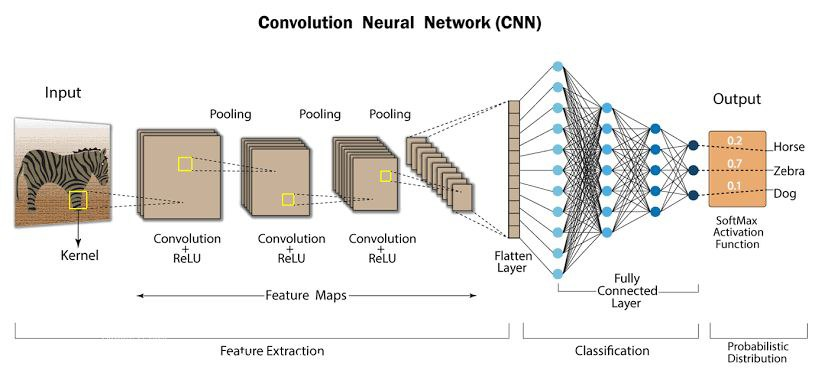

In [ ]:
batch = next(train_generator)
first_image = batch[0][0]  
image_size = first_image.shape
image_size

In [ ]:
model = Sequential()

# Add convolutional/pooling layers

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_size, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_size, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_size, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add flatten layer
model.add(Flatten())

# Add dense/dropout layers + activation functions

model.add(Dense(128))
model.add(Activation('relu'))# relu activation function for deep layer
model.add(Dropout(0.2))

model.add(Dense(5))
model.add(Activation('softmax'))

# Print summary of your model
model.summary()

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

K.clear_session()

#find a lr
def lr_schedule(epoch):
    lr = 0.001 * 0.9**epoch
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

history=model.fit(train_generator,
          epochs=20,
          validation_data=validation_generator,
             callbacks=[lr_scheduler])
history

In [ ]:
plot_accur(history, epochs=20)

In [ ]:
plot_lr(history, epochs=20)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = []
classes = train_crop.label.unique()

for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]  
    predicted_classes.append(predicted_class)  
submission = test_df.copy()
submission.loc[:, 'label'] = predicted_classes
cols=['image_id', 'label']
submission = submission[cols]
submission

In [ ]:
#Add regularization and learning rate=0.001

from tensorflow.keras import regularizers
model = Sequential()

# Add convolutional/pooling layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_size, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_size, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=image_size, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add flatten layer
model.add(Flatten())

# Add dense/dropout layers + activation functions with L2 regularization
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(5, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

In [ ]:
K.clear_session()
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',  
              metrics=['accuracy'])
history=model.fit(train_generator,
          epochs=20,
          validation_data=validation_generator)
history

In [ ]:
plot_accur(history, epochs=20)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = []
classes = train_crop.label.unique()

for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]  
    predicted_classes.append(predicted_class)  
submission = test_df.copy()
submission.loc[:, 'label'] = predicted_classes
cols=['image_id', 'label']
submission = submission[cols]
submission

# SPECIAL NETWORK MODELS

- **ResNet:** Leveraging its depth and performance to identify subtle patterns in cancer cell images.

- **Inception:** Efficiently utilizing computational resources to detect unique features indicative of different cancer types.

- **MobileNet:** Balancing speed and accuracy, making it ideal for analyzing large volumes of cell tissue samples.

- **EfficientNet:** Offering state-of-the-art performance, which could be beneficial in achieving high classification accuracy for ovarian cancer types.

- **VGGNet:** Providing a simple yet effective approach, making it a good starting point for educational purposes or as a baseline model.

## ResNet

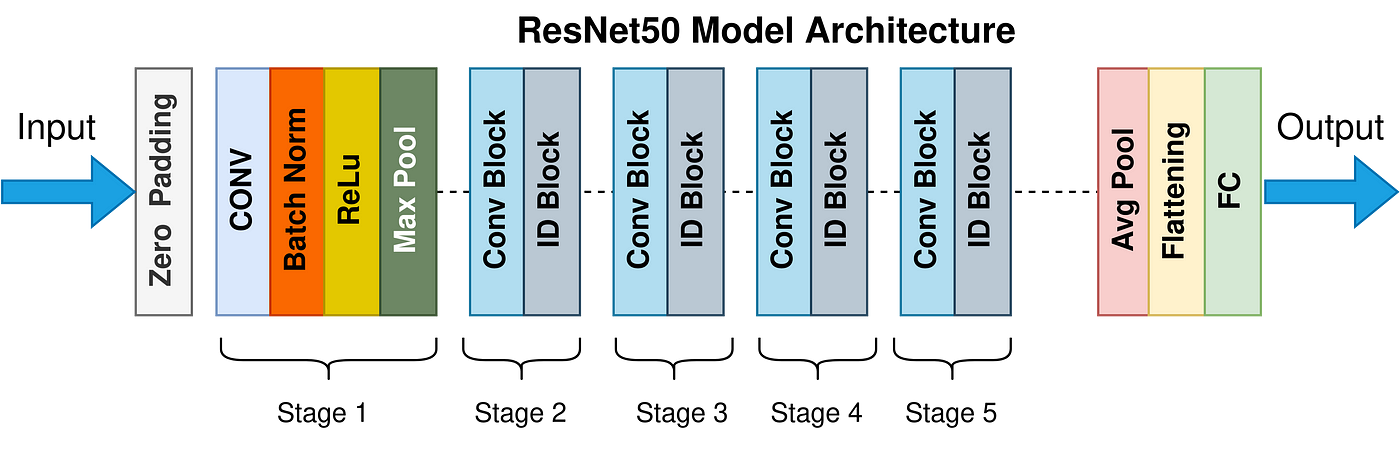

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam,Adamax

# Load pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights=None, include_top=False, input_shape=image_size)

# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling layer
x = layers.Dense(256, activation='relu')(x)  # Dense layer with 256 units and ReLU activation
predictions = layers.Dense(5, activation='softmax')(x)  # Output layer with softmax activation for num_classes classes

# Create the final model
model_rn = models.Model(inputs=base_model.input, outputs=predictions)
K.clear_session()
# Compile the model
model_rn.compile(optimizer=Adamax(lr=0.0001),  # You can adjust the learning rate
              loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class classification
              metrics=['accuracy'])
history_rn = model_rn.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
)
history_rn

In [ ]:
plot_accur(history_rn, epochs=20)

In [ ]:
predictions = model_rn.predict(test_generator)
predicted_classes = []
classes = train_crop.label.unique()

for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]  
    predicted_classes.append(predicted_class)  
submission = test_df.copy()
submission.loc[:, 'label'] = predicted_classes
cols=['image_id', 'label']
submission = submission[cols]
submission

## EfficientNet

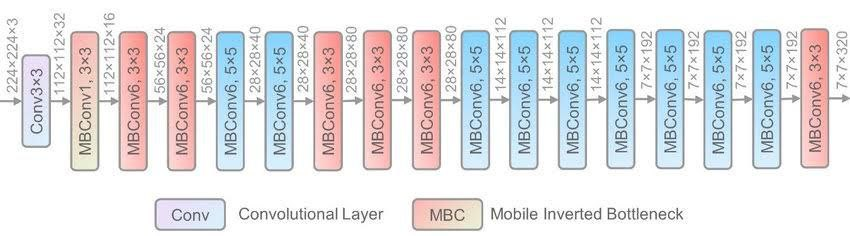

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

# Load pre-trained EfficientNetB0 model without the top (classification) layer
base_model = EfficientNetB7(weights=None, include_top=False, input_shape=image_size)

# Add your own classification layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  
x = Dense(256, activation='relu')(x)  
predictions = Dense(5, activation='softmax')(x)  

# Create the final model
model_en = Model(inputs=base_model.input, outputs=predictions)
K.clear_session()
# Compile the model
model_en.compile(optimizer=Adam(lr=0.001),  
              loss='categorical_crossentropy',  
              metrics=['accuracy'])
history_en = model_en.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
)
history_en

In [ ]:
plot_accur(history_en, epochs=10)

In [ ]:
predictions = model_en.predict(test_generator)
predicted_classes = []
classes = train_crop.label.unique()

for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]  
    predicted_classes.append(predicted_class)  
submission = test_df.copy()
submission.loc[:, 'label'] = predicted_classes
cols=['image_id', 'label']
submission = submission[cols]
submission

<a id="4"></a>
<h2 style='background:violet; border:0; color:white'><center>4. Conclusions</center><h2>

After several efforts of image transformation, different augmentation and models architecture, the quality of predictions is still low - like random guess (and most cases the test image was classified as CC type). The maximum accuracy was achieved for test data - 0.7337. The model could classify the test image (HGSC) as CC with 47% of accuracy and as HGSC with 33%.

**The possible reasons:**

1. Small sample of training data - just 500 pictures

2. The histologic samples were given in very variable formats, and it should be highly zoomed to get important cellular details. This rocedure is memory exhasting and impossible in resent conditions.

3. Possible options to improve predictions:
 - use library histolabs, which can provide detailed slices of images
 - simplification of models with Network Auto-Reduction (NAR) and ResRep - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9197439/
 - Inception module

## Inception

**Multi-scale Processing**:
Inception modules use filters of different sizes (1x1, 3x3, 5x5) simultaneously. This allows the network to capture patterns at different scales in the input data.

**Parameter Efficiency**:
1x1 convolutions are used to reduce the number of input channels before applying larger convolutions. This helps in reducing the number of parameters and computational cost.

**Computational Efficiency**:
By using parallel convolutions and concatenating their outputs, the network can process information in a computationally efficient manner.

**Network Depth**:
The architecture allows for effective training of very deep networks. This was crucial as deeper networks were found to perform better on certain tasks.

**Global Average Pooling**:
The architecture uses global average pooling instead of fully connected layers in the final layers. This reduces the risk of overfitting and decreases the number of parameters.

**Feature Reuse**:
The network encourages feature reuse by using 1x1 convolutions. This enables the network to learn a variety of low and high-level features.

**High Accuracy**:
Inception architectures have achieved state-of-the-art performance on various image classification tasks, demonstrating their effectiveness.

**Versatility**:
The Inception architecture has been used as a base architecture for other tasks beyond image classification, such as object detection (in the context of the Inception V2 and V3 models).

Inception runs the memory out - therefore its complicated to apply here

def inception_module(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    
    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)
    
    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)
    
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)
    
    inception = concatenate([conv1x1, conv3x3, conv5x5, maxpool_proj], axis=-1)
    
    return inception

input_shape = (100, 100, 3)
input_layer = Input(shape=input_shape)

inception1 = inception_module(input_layer, [64, 128, 128, 32, 32, 32])
inception2 = inception_module(inception1, [128, 192, 192, 64, 64, 64])

flatten = Flatten()(inception2)
dense1 = Dense(256, activation='relu')(flatten)
output_layer = Dense(5, activation='softmax')(dense1)  # Adjust num_classes based on your task

inception_model = Model(inputs=input_layer, outputs=output_layer)

inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = inception_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)

history

# Production

In [ ]:
import os
import pickle
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

class MyTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def transform(self, input_path, output_folder, d):
        def crop_d(image, n):
            width, height = image.size
            width = width // n
            cropped_image = image.crop((0, 0, width, height))
            return cropped_image

        def zoom1(image, w=100, h=100):
            image = image.convert('RGBA')
            image_data = list(image.getdata())
            black_threshold = 50
            mask = [(0, 0, 0, 0) if all(item < black_threshold for item in pixel[:3]) else pixel for pixel in image_data]
            image.putdata(mask)
            bbox = image.getbbox()
            center_x = (bbox[0] + bbox[2]) // 2
            center_y = (bbox[1] + bbox[3]) // 2
            crop_width = w
            crop_height = h
            left = center_x - crop_width
            upper = center_y - crop_height
            right = center_x + crop_width
            lower = center_y + crop_height
            crop_image = image.crop((left, upper, right, lower))
            return crop_image

        if d == '1':
            image = Image.open(input_path)
            image = zoom1(image, w=100, h=100)
            output_path = os.path.join(output_folder, 'processed_img_1.png')  # Unique name for each processed image
            image.save(output_path)

        elif d == '2':
            image = Image.open(input_path)
            image = crop_d(image, 2.5)
            image = zoom1(image, w=100, h=100)
            output_path = os.path.join(output_folder, 'processed_img_2.png')
            image.save(output_path)

        elif d == '3':
            image = Image.open(input_path)
            image = crop_d(image, 4.5)
            image = zoom1(image, w=100, h=100)
            output_path = os.path.join(output_folder, 'processed_img_3.png')
            image.save(output_path)

        elif d == '4':
            image = Image.open(input_path)
            image = crop_d(image, 5.5)
            image = zoom1(image, w=100, h=100)
            output_path = os.path.join(output_folder, 'processed_img_4.png')
            image.save(output_path)

        return output_path

# Load pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(5, activation='softmax')(x)

# Create the final model
model_rn = models.Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model_rn.compile(optimizer=Adamax(lr=0.0001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
model_rn.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
)
model_rn.save_weights('/kaggle/working/weights.h5')

# Create the pipeline
pipe = Pipeline([
    ('FeatureEngineering', MyTransformer()),
    ('ResNet', model_rn)
])


# Save the entire pipeline
with open('/kaggle/working/my_new_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)


In [ ]:
# Example usage
input_path = '/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png'
output_folder = '/kaggle/working/pipe_output'
os.makedirs(output_folder, exist_ok=True)

d = '1'  # or '2', '3', '4'

# Transform input image
processed_image_path = pipe.named_steps['FeatureEngineering'].transform(input_path, output_folder, d)

# Load the model and make predictions
loaded_model = pipe.named_steps['ResNet']
loaded_model.load_weights('/kaggle/working/weights.h5')  # Load your saved model weights

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load and preprocess a single image
img = image.load_img(processed_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Create ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1./255.)

# Use flow method to generate batches
processed_image = test_datagen.flow(
    x=img_array,
    batch_size=1,
    shuffle=False
)

# Now you can make predictions
predictions = loaded_model.predict(processed_image)
predicted_classes = []
classes = ['HGSC', 'EC', 'CC', 'LGSC', 'MC']
for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]  
    predicted_classes.append(predicted_class) 

print(predictions,
     predicted_classes)